# Anime DCGAN - Image Generation

## Table of Contents
1. [Introduction](#introduction)
2. [Dataset](#dataset)
    1. [Kaggle Data Input](#kaggle-data-input)
    2. [Installing and Loading Necessary Libraries](#installing-and-loading-necessary-libraries)
    3. [Setting up Seed for Code Regeneration](#setting-up-seed-for-code-regeneration)
    4. [Preprocessing Data](#preprocessing-data)
3. [Model Design](#model-design)
    1. [Creating a Generator Architecture](#creating-a-generator-architecture)
    2. [Creating a Discriminator Architecture](#creating-a-discriminator-architecture)
4. [Loss Functions and Optimizers](#loss-functions-and-optimizers)
5. [Model Training](#model-training)
    1. [Initialization and Weight Functions](#initialization-and-weight-functions)
    2. [Lists for Storing Losses and Images](#lists-for-storing-losses-and-images)
    3. [Event Handlers for Storing Losses and Images](#event-handlers-for-storing-losses-and-images)
    4. [Starting the Training Process](#starting-the-training-process)
6. [Evaluation Metrics](#evaluation-metrics)
    1. [Frechet Inception Distance (FID) and Inception Score (IS)](#frechet-inception-distance-fid-and-inception-score-is)
    2. [Loss of Generator (LossG) and Loss of Discriminator (LossD)](#loss-of-generator-lossg-and-loss-of-discriminator-lossd)
7. [Model Comparision](#model-comparision)
    1. [Loss Comparision](#loss-comparision)
    2. [Frechet Inception Distance (FID) and Inception Score (IS)](#frechet-inception-distance-fid-and-inception-score-is-1)
    3. [Images Generated](#images-generated)
8. [Conclusion](#conclusion)
9. [Saving the Model for Future Use](#saving-the-model-for-future-use)



### Introduction
- This is project to demonstrate DCGAN architecture to generate Images trained on the dataset.
- The main of the architecture and parameters are in inspired from the very first research paper on DCGANs. 
> https://arxiv.org/abs/1511.06434
>    - UNSUPERVISED REPRESENTATION LEARNING
>    - WITH DEEP CONVOLUTIONAL
>    - GENERATIVE ADVERSARIAL NETWORKS
>    - 2016
- Data is taken from kaggle - The ANIME dataset.
- Kaggles Virtual machine were used, Tesla T4x2 to be precise.
- We might had used colab but it would need the data to be injected manuaaly from outside (i.e. downloading it and uploading it).
- The training took about 20 hrs in total for different architectures applied.

**DCGAN Model**

DCGAN, short for Deep Convolutional Generative Adversarial Network, is a type of neural network architecture designed for generating realistic images. It consists of two main components:
![model](output_images/DCGAN.png)

1. **Generator:**
   - Responsible for generating synthetic images.
   - Utilizes convolutional layers to transform random noise into meaningful data.
   - Output is intended to resemble real data from the training set.

2. **Discriminator:**
   - Functions as a binary classifier (real or fake) for images.
   - Employs convolutional layers to analyze and classify input images.
   - Trained to distinguish between genuine and generated images.

DCGANs are trained in a competitive manner where the generator improves its ability to generate realistic images by fooling the discriminator, and the discriminator enhances its accuracy in distinguishing real from generated images. This adversarial training process leads to the development of a generator capable of creating high-quality, authentic-looking images.


### Dataset
- We use Anime Dataset available on Kaggle https://www.kaggle.com/datasets/splcher/animefacedataset
- This dataset has 63,632 "high-quality" anime faces.
- We use this dataset becauase it has a large number of images, which is benificial for training purpose

##### Kaggle Data Input

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images/35715_2011.jpg
/kaggle/input/images/48610_2014.jpg
/kaggle/input/images/34719_2011.jpg
/kaggle/input/images/40266_2012.jpg
/kaggle/input/images/4199_2002.jpg
/kaggle/input/images/40739_2013.jpg
/kaggle/input/images/42515_2013.jpg
/kaggle/input/images/52482_2015.jpg
/kaggle/input/images/46555_2014.jpg
/kaggle/input/images/11579_2005.jpg
/kaggle/input/images/36943_2012.jpg
/kaggle/input/images/9787_2004.jpg
/kaggle/input/images/3388_2002.jpg
/kaggle/input/images/8393_2004.jpg
/kaggle/input/images/30352_2010.jpg
/kaggle/input/images/10908_2005.jpg
/kaggle/input/images/22363_2008.jpg
/kaggle/input/images/51151_2015.jpg
/kaggle/input/images/59491_2018.jpg
/kaggle/input/images/3809_2002.jpg
/kaggle/input/images/59579_2018.jpg
/kaggle/input/images/36325_2012.jpg
/kaggle/input/images/63045_2019.jpg
/kaggle/input/images/16752_2007.jpg
/kaggle/input/images/795_2000.jpg
/kaggle/input/images/43101_2013.jpg
/kaggle/input/images/42450_2013.jpg
/kaggle/input/images/45675_2014.jpg

#### Installing and loading Necessary Libraries

In [2]:
!pip install pytorch-ignite
!pip install torchsummary

In [3]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import ignite
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from ignite.engine import Engine, Events
import ignite.distributed as idist

#### Setting up Seed for code regeneration

In [4]:
ignite.utils.manual_seed(999)
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<_Logger ignite.distributed.launcher.Parallel (WARNING)>

#### Preprocessing Data
- **Prerocessing includes:**
    - Resize images to a square of size 64x64 pixels
    - Perform a center crop to focus on the central region of each image
    - Convert the images to PyTorch tensors
    - Normalize the pixel values to a range of [-1, 1] using mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5)
- **Load Training Dataset:**
    - Create a training dataset using the ImageFolder class.
    - Specify the root directory where the dataset is located and apply the defined data transformations.
    
- **Create Testing Subset:**
    - Generate a subset of the training dataset for testing.
    - The subset is created by selecting the first 3000 samples.

In [5]:
from torchvision.datasets import ImageFolder
image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = ImageFolder(root="/kaggle/input", transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))

- **Set Batch Size:**
  - Define the batch size for training and testing datasets (here it is 128).
  - Batch Size can be chosen larger but it will lead in poor result. Same is the case for smaller batches.
- **Creating Training Dataloader**
- **Creating Testing Dataloader**
    - Why create a testing dataset?
        - Testing dataset plays a crucial role in evaluating the GAN's performance, both quantitatively through metrics like FID and IS, and qualitatively through visual inspection of generated images.

In [6]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)


- Displaying the images from the train dataset

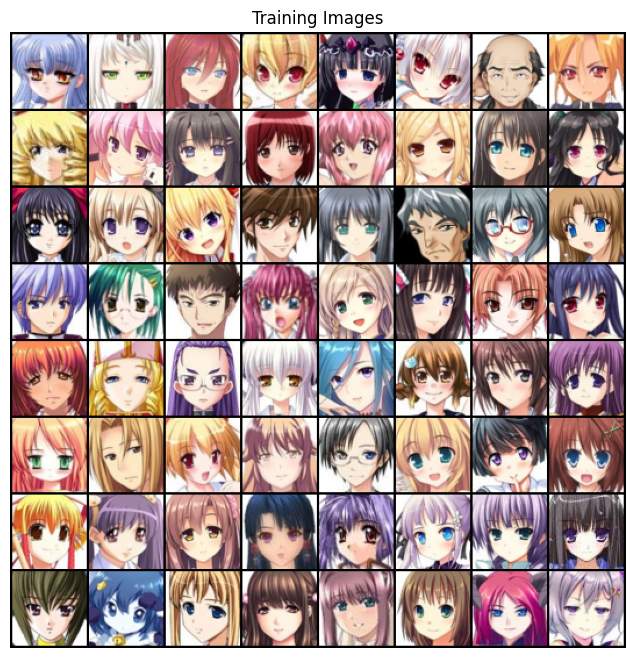

In [7]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

#### Defining Variables to be used in the program later on

In [8]:
# Defining Variables:
# Number of GPUs available We would use 0 for CPU mode.
ngpu = 1
'''
The feature maps and latent vector size depends solely on the researcher, here considering the 
computational cost and time complexity we take them to be 64 and 100 respectively.
We can lower the feature maps and the latent vector but, it will return poor results, but
increasing the value result in computational cost
'''
# Size of feature maps in discriminator
ndf = 64
# Size of feature maps in generator
ngf = 64
# Number of channels in the training images. For color images this is 3
nc = 3
#  latent space dimension of input vectors for the generator
latent_dim = 100
'''
For number of epochs we start with atleast 5 to check out the result and keep on incresing
this value.
'''
# Number of training epochs
# num_epochs = 5 
# num_epochs = 25
num_epochs = 50
# num_epochs = 100

# Learning rates
'''
Learning rate for optimizers is preferred to be selected to be very low, good to go
with 0.0002 or we may select even smaller value but it may result in computational cost.
'''
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

### Model Design

#### Creating a Generator Architecture

In [9]:
#Generator
'''
>   This model is motivated from the research paper from:
    https://arxiv.org/abs/1511.06434
    UNSUPERVISED REPRESENTATION LEARNING
    WITH DEEP CONVOLUTIONAL
    GENERATIVE ADVERSARIAL NETWORKS
    2016

>   The generator gradually upsamples the input noise through a series of transposed
    convolutional layers with batch normalization and ReLU activation until the final
    layer produces an output tensor with the same dimensions as the target images
    (64x64 in this case).
    
> Please refer to the research paper page 3-4.

> We have reduced the model architecture (in the research paper) starting from 1024
channels to 512 channels to take in account for the computational costs.
'''

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #for refernce:
            #nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
            # input is Z, going into a convolution
            
         # Input: 1x1x100, Output: 4x4x512
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # Input: 4x4x512, Output: 8x8x256
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Input: 8x8x256, Output: 16x16x128
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Input: 16x16x128, Output: 32x32x64
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Input: 32x32x64, Output: 64x64x3
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Tanh activation function to map values to the image pixel range (e.g., [-1, 1]).
        )

    def forward(self, input):
        return self.main(input)

#### Explainantion for the Generator network:
- We use TransposeConv2d for upsampling the input.
- We select the Size of feature maps in generator and the Size of feature maps in discriminatoras 64 to both, because larger this value more potentially allow the model to capture more complex features but may require more computational resources. We might had selescted 32 or less but it may give poor result. Therefore we select 64 as a good point to start with.
- A larger latent vector might allow the generator to capture more intricate patterns. Therefore we select it to be 100.


- The generator has an input of a 1x1x100 vector, and the wanted output is a 3x64x64.
- We have the formula to evaluate the output size:
$$n_{\text{out}} = (n_{\text{in}} -1)\times s - 2p + (k-1) +1$$

```
# The first layer:
nn.ConvTranspose2d( in_channels=100, out_channels=512, 
                               kernel_size=4, stride=1, padding=0,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
```
$$n_{\text{out}} = (1-1)\times 1 - 2\times 0 + (4-1) +1  = 4$$

- The output size of the transposed convolution is 4x4, as indicated in the code.

- The next four convolutional layers are identical with a kernel size of four, a stride of two and a padding of one. This doubles the size of each input. So 4x4 turns to 8x8, then 16x16, 32x32 and finally, 64x64.

- **Batch normalization** standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

- **Activation function ReLU** is used to address the vanishing gradient problem in deep convolutional neural networks and promote sparse activations (e.g. lots of zero values).

In [10]:
# Generator architecture visualized
netG = idist.auto_model(Generator(latent_dim))
idist.device()
summary(netG, (latent_dim, 1, 1))

2024-01-19 10:47:26,408 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
   ConvTranspose2d-2            [-1, 512, 4, 4]         819,200
       BatchNorm2d-3            [-1, 512, 4, 4]           1,024
       BatchNorm2d-4            [-1, 512, 4, 4]           1,024
              ReLU-5            [-1, 512, 4, 4]               0
   ConvTranspose2d-6            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-7            [-1, 256, 8, 8]             512
              ReLU-8            [-1, 256, 8, 8]               0
   ConvTranspose2d-9          [-1, 128, 16, 16]         524,288
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
  ConvTranspose2d-12           [-1, 64, 32, 32]         131,072
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

#### Creating a Discriminator architecture

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # Input: 64x64x3, Output: 32x32x64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 32x32x64, Output: 16x16x128
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 16x16x128, Output: 8x8x256
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 8x8x256, Output: 4x4x512
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 4x4x512, Output: 1x1x1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Sigmoid activation to map the output to a probability (0 to 1)
        )

    def forward(self, input):
        return self.main(input)


#### Explainantion for the Discriminator network:
- We use Conv2d for downsampling the input (i.e. the output generated by the generator.).
- The input size to the discriminator is a 3x64x64 image, the output size is a binary 1x1 scalar. 
- We have the formula to evaluate the output size:

$$
n_{\text{out}} = \frac{{(n_{\text{in}} + 2p - k)}}{s} + 1
$$


```
# The first layer:
# Input: 64x64x3, Output: 32x32x64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),            
```
$$n_{\text{out}} = \frac{64 + 2\times1 - 4}{2} + 1 = 32$$
- The output size of the transposed convolution is 4x4, as indicated in the code.

- The next four convolutional layers are identical with a kernel size of four, a stride of two and a padding of one. This doubles the size of each input. So 4x4 turns to 8x8, then 16x16, 32x32 and finally, 64x64.

#### Why using the leaky relu?
- Leaky ReLU (Rectified Linear Unit) is a type of activation function that allows a small, non-zero gradient when the input is negative. It is defined as:

$$
\text{Leaky ReLU}(x) = \begin{cases} 
x & \text{if } x > 0 \\
\text{negative\_slope} \times x & \text{otherwise}
\end{cases}
$$
- ReLU is recommended for the generator, but not for the discriminator model. Instead, a variation of ReLU that allows values less than zero, called Leaky ReLU, is preferred in the discriminator.


In [12]:
# Visualizing the Discriminator Architecture
ngpu = 1
netD = idist.auto_model(Discriminator(ngpu))
summary(netD, (3, 64, 64))


2024-01-19 10:47:28,366 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
            Conv2d-2           [-1, 64, 32, 32]           3,072
         LeakyReLU-3           [-1, 64, 32, 32]               0
         LeakyReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,072
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         LeakyReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         131,072
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        LeakyReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11            [-1, 256, 8, 8]         524,288
      BatchNorm2d-12            [-1, 256, 8, 8]             512
        LeakyReLU-13            [-1, 256, 8, 8]               0
           Conv2d-14            [-1, 25

#### Loss functions and Optimizers

In [13]:
#Loss functions and Optimizers
# Initialize BCELoss function
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())
'''
fixed_noise is a 4-dimensional tensor with a shape of (64, 100, 1, 1). Each of the
64 samples has 100 values, and the spatial dimensions are 1x1.
'''

# Setup Adam optimizers for both G and D
'''
Additionally, we find leaving the momentum term β1 at the suggested value of 0.9
resulted in training oscillation and instability while reducing it to 0.5 helped
stabilize training.
'''
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

### Model Training

#### Desription of the training steps involed 
- In short, during each training step, the discriminator is trained to distinguish between real and fake data, while the generator is trained to generate data that can "fool" the discriminator into classifying it as real. The losses and metrics are then returned for monitoring the training process.



In [14]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

**Since, we use Pytorch and ignite. We follow the Documentation provided to start the training process**
- Steps involved:
    1. Engine Initialization: `trainer = Engine(training_step)`
        - Initializes an Ignite Engine for training using the training_step function defined earlier. The training_step function represents one iteration of the training process.
    2. Weight Initialization Function: `initialize_fn(m)`
        - This function initializes the weights of the neural network (netD and netG). It uses normal distribution for weights and sets them based on the type of layer (Convolutional or BatchNorm). This function is applied to the model weights during the training process.
    3. Initialization of Weights at the Start:
        - `@trainer.on(Events.STARTED)`:
            - Registers an event handler to be triggered when the training starts.
        - `init_weights()`:
            - Applies the weight initialization function (initialize_fn) to the discriminator (netD) and generator (netG) models.
    4. Lists for Storing Losses and Images:
        - `G_losses` and `D_losses` are lists initialized to store generator and discriminator losses during training.
        - img_list is initialized to store generated images at specific intervals.

    5. Event Handler for Storing Losses:
        - `@trainer.on(Events.ITERATION_COMPLETED)`:
            - Registers an event handler to be triggered after each iteration of the training process.
        - `store_losses(engine)`:
            - Appends the generator and discriminator losses (Loss_G and Loss_D) from the current iteration to the respective lists (G_losses and D_losses).
    6. Event Handler for Storing Images:
        - `@trainer.on(Events.ITERATION_COMPLETED(every=500))`:
            - Registers an event handler to be triggered after every 500 iterations.
        - `store_images(engine)`:
            - Generates fake images using the generator (netG) with a fixed noise vector (fixed_noise) and appends them to the img_list.

In [15]:
trainer = Engine(training_step)

def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)
    
G_losses = []
D_losses = []
@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])
    
img_list = []
@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)



### Model Evaluation Metrics

#### Frechet Inception Distance (FID) and Inception Score (IS)

- **Frechet Inception Distance (FID):**
  - Measures the similarity between real and generated images.
  - Lower FID indicates better quality and diversity of generated images.
  - Computed using statistics from the InceptionV3 model.

- **Inception Score (IS):**
  - Measures the quality and diversity of generated images.
  - Higher IS indicates better image quality and diversity.
  - Calculated based on the predicted class probabilities from the InceptionV3 model.

#### Loss of Generator (LossG) and Loss of Discriminator (LossD)

- **Loss of Generator (LossG):**
  - Measures how well the generator is performing.
  - A lower LossG indicates the generator is producing more realistic images.

- **Loss of Discriminator (LossD):**
  - Measures how well the discriminator is distinguishing between real and generated images.
  - A lower LossD indicates better performance of the discriminator.


In [16]:
# Code to evaluate the FID and IS values
from ignite.metrics import FID, InceptionScore
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])
import PIL.Image as Image

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 214MB/s]  


In [17]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [18]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")


In [19]:
# Code to evaluate the Loss_G and Loss_D
from ignite.metrics import RunningAverage
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [20]:
# To display a animated prgress bar while trainig
from ignite.contrib.handlers import ProgressBar
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)


/opt/conda/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:126: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Starting the training Process

In [21]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=num_epochs)

with idist.Parallel(backend='gloo') as parallel:
    parallel.run(training)

[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [1/5] Metric Scores
*   FID : 0.092528
*    IS : 1.232602


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [2/5] Metric Scores
*   FID : 0.062390
*    IS : 1.526777


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [3/5] Metric Scores
*   FID : 0.049680
*    IS : 1.605888


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [4/5] Metric Scores
*   FID : 0.064393
*    IS : 1.634396


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [5/5] Metric Scores
*   FID : 0.052414
*    IS : 1.832189


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [6/5] Metric Scores
*   FID : 0.033418
*    IS : 1.864371


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [7/5] Metric Scores
*   FID : 0.032965
*    IS : 1.921214


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [8/5] Metric Scores
*   FID : 0.040548
*    IS : 1.971388


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [9/5] Metric Scores
*   FID : 0.043563
*    IS : 2.001328


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [10/5] Metric Scores
*   FID : 0.031892
*    IS : 1.919144


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [11/5] Metric Scores
*   FID : 0.029901
*    IS : 1.967773


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [12/5] Metric Scores
*   FID : 0.051830
*    IS : 1.798054


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [13/5] Metric Scores
*   FID : 0.034612
*    IS : 1.895305


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [14/5] Metric Scores
*   FID : 0.068665
*    IS : 1.901061


[1/496]   0%|           [00:00<?]

Epoch [15/5] Metric Scores
*   FID : 0.055379
*    IS : 1.802538


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [16/5] Metric Scores
*   FID : 0.031149
*    IS : 1.867025


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [17/5] Metric Scores
*   FID : 0.054765
*    IS : 1.882867


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [18/5] Metric Scores
*   FID : 0.047288
*    IS : 1.875450


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [19/5] Metric Scores
*   FID : 0.030543
*    IS : 1.855476


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [20/5] Metric Scores
*   FID : 0.035573
*    IS : 1.916125


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [21/5] Metric Scores
*   FID : 0.028669
*    IS : 1.864725


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [22/5] Metric Scores
*   FID : 0.028219
*    IS : 1.933299


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [23/5] Metric Scores
*   FID : 0.047376
*    IS : 1.918687


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [24/5] Metric Scores
*   FID : 0.037012
*    IS : 1.890866


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [25/5] Metric Scores
*   FID : 0.027528
*    IS : 1.950281


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [26/5] Metric Scores
*   FID : 0.025206
*    IS : 1.845309


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [27/5] Metric Scores
*   FID : 0.039422
*    IS : 1.893312


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [28/5] Metric Scores
*   FID : 0.035015
*    IS : 1.867401


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [29/5] Metric Scores
*   FID : 0.032532
*    IS : 1.965997


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [30/5] Metric Scores
*   FID : 0.029746
*    IS : 1.910425


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [31/5] Metric Scores
*   FID : 0.031182
*    IS : 1.851514


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [32/5] Metric Scores
*   FID : 0.034807
*    IS : 1.939996


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [33/5] Metric Scores
*   FID : 0.021401
*    IS : 1.920257


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [34/5] Metric Scores
*   FID : 0.037656
*    IS : 1.929852


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [35/5] Metric Scores
*   FID : 0.031460
*    IS : 1.888925


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [36/5] Metric Scores
*   FID : 0.028579
*    IS : 1.918808


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [37/5] Metric Scores
*   FID : 0.022142
*    IS : 1.946780


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [38/5] Metric Scores
*   FID : 0.016991
*    IS : 1.964886


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [39/5] Metric Scores
*   FID : 0.022372
*    IS : 1.951035


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [40/5] Metric Scores
*   FID : 0.021297
*    IS : 1.952579


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [41/5] Metric Scores
*   FID : 0.023552
*    IS : 1.937626


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [42/5] Metric Scores
*   FID : 0.031461
*    IS : 1.918074


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [43/5] Metric Scores
*   FID : 0.027742
*    IS : 1.910088


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [44/5] Metric Scores
*   FID : 0.015118
*    IS : 1.964804


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [45/5] Metric Scores
*   FID : 0.032373
*    IS : 1.843667


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [46/5] Metric Scores
*   FID : 0.025764
*    IS : 1.963024


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [47/5] Metric Scores
*   FID : 0.025726
*    IS : 1.946284


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [48/5] Metric Scores
*   FID : 0.030713
*    IS : 1.933119


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [49/5] Metric Scores
*   FID : 0.023107
*    IS : 1.918421


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [50/5] Metric Scores
*   FID : 0.017378
*    IS : 1.948543


#### Losses of Generator and Discriminator

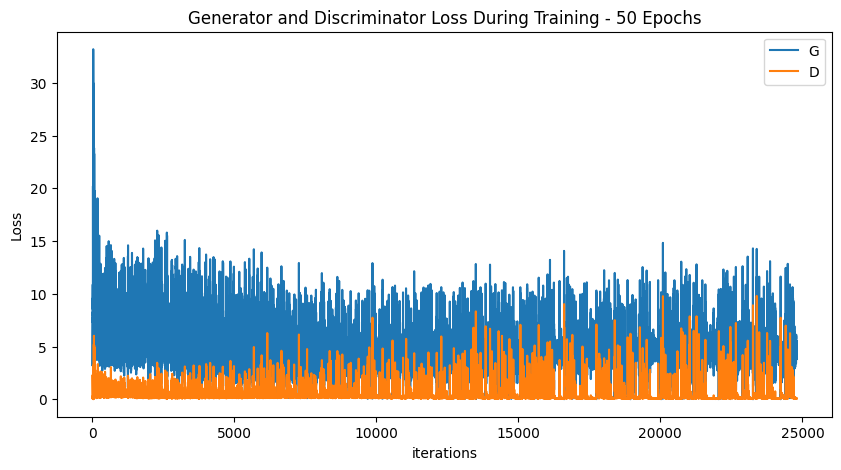

In [26]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training - 50 Epochs")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot_epoch50.png")



#### FID and IS values

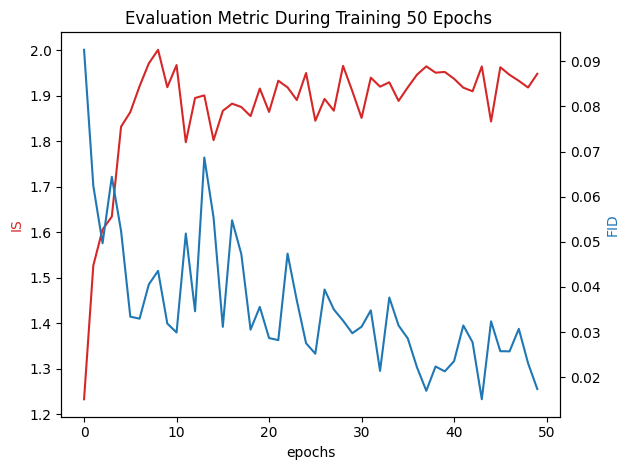

In [27]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training 50 Epochs ")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()
plt.savefig("FID and IS for 50 epoch.png")


#### Visual Inspection

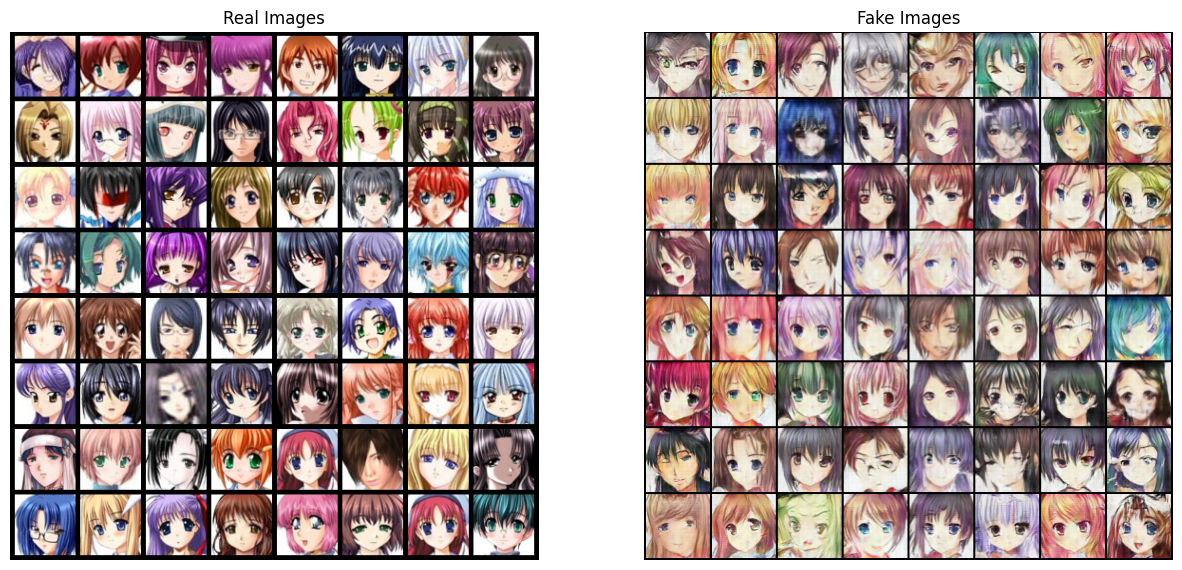

In [28]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(test_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig("Real Vs Fake at 50 Epoch.png")


### Model Comparision
#### Loss Comparision
> - **Model with 5 Epochs**
![Losses_5_Epoch](output_images/loss_plot_5_epoch.png)
- We can see a lot of fluctuations in the graph. It is not stable, also the loss values are high for the Generator
> - **Model with 25 Epochs**
![Losses_25_Epoch](output_images/loss_plot_epoch_25.png)
- Now, the fluctuations is now more stable  in the graph as it approach the last epoch. We may, try for number of epochs.
> - **Model with 50 Epochs**
![Losses_50_Epoch](output_images/loss_plot_epoch_50.png)
- Now, the fluctuations is now more stable than the both the above graph (Epoch 5 and 25).

#### Frechet Inception Distance (FID) and Inception Score (IS)
> - **Model with 5 Epochs**
![FID_IS_5_Epoch](output_images/FID_IS_5_epoch.png)
- We can see a lot of fluctuations in the graph. It is not stable, we would like to see higher epoch values.
> - **Model with 25 Epochs**
![FID_IS_25_Epoch](output_images/FID_IS_25_epoch.png)
- We can see that the fluctuations in the graph are more stable and indicate that if we go for more epochs the FID score may get higher and the IS values may also drop.
> - **Model with 50 Epochs**
![FID_IS_50_Epoch](output_images/FID_IS_50_epoch.png)
- Now, the FID and IS values are oscillating among the same ranges respectively. But, we can go for more epoch or may increase the architecture size of the model.

#### Images Generated
> - **Model with 5 Epochs**
![Image_generated_5_Epoch](output_images/Real_Fake_5_Epoch.png)
- We see that images generated are not clear and produce non-suitable output.
> - **Model with 25 Epochs**
![Image_generated_25_Epoch](output_images/Real_Fake_25_Epoch.png)
- Images are much clear and better, we may go for further epochs.
> - **Model with 50 Epochs**
![Image_generated_50_Epoch](output_images/Real_Fake_50_Epoch.png)
- Images are now more clear and of more suitable output. Therefore, 50 Epochs might be a good to go value.




#### Conclusion
- We may conclude that the results get improving when we increase the epochs, and give better result at 50 epoch.
- One thing to note is taht we may increase the highest number of output channel from 512 to even more greater values. This may give us better result. But, overall increses the computational cost. As the Dataset is very large it will take a lot of time and computational cost. As this model took about 3 hrs for the 50 epochs (one may understand the time complexity and computational cost). 
- Therefore, we stop at 50 epochs and the channel size to 512 only.

### Saving the model for future use

In [31]:
torch.save(netG.state_dict(), 'generator_50_epoch.pth')
torch.save(netD.state_dict(), 'discriminator_50_epoch.pth')